### Loading and Inspecting the Data

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

filename = "files/001.csv"
df_all_data = pd.read_csv(filename)

In [2]:
df_all_data

,property,floors,price
0,a,3,1000
1,b,4,1500
2,c,6,3000
3,d,8,3200
4,e,2,1200
5,f,9,4000
6,g,10,4200
7,h,11,5000
8,i,12,5500
9,j,15,7000


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'price (USD)')

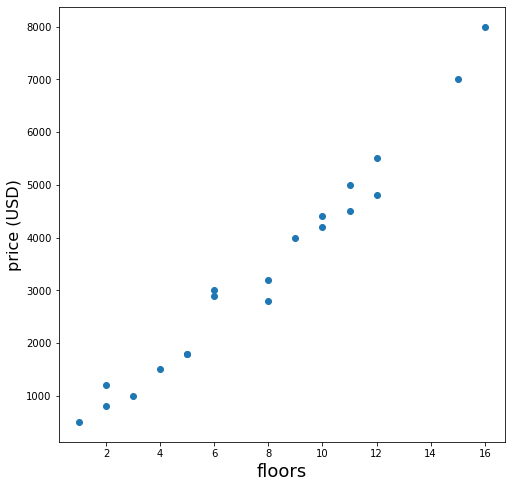

In [4]:
plt.rcParams["figure.figsize"] = (8,8) 
plt.scatter(df_all_data.floors, df_all_data.price)
plt.xlabel('floors', fontsize=18) 
plt.ylabel('price (USD)', fontsize=16) 

### Performing the train-test split

In [5]:
from sklearn.model_selection import train_test_split

X = df_all_data['floors'].values 
y = df_all_data['price'].values
# X = df_all_data.drop(['price', 'property'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
X_train

array([10, 10,  2,  6,  9, 11, 15, 11,  1,  5,  8,  3, 12,  8])

In [7]:
y_train

array([4200, 4400, 1200, 3000, 4000, 4500, 7000, 5000,  500, 1800, 3200,
       1000, 4800, 2800])

In [8]:
X_test

array([ 5,  4,  6, 12, 16,  2])

In [9]:
y_test

array([1800, 1500, 2900, 5500, 8000,  800])

### Training and Deploying a Linear Learner model

In [11]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

In [17]:
from sagemaker import LinearLearner

estimator = LinearLearner(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    predictor_type='regressor', 
    mini_batch_size=4
)

In [18]:
# upload into S3 
record_set = estimator.record_set(train=X_train.reshape(-1,1).astype('float32'), labels=y_train.astype('float32'))

In [19]:
record_set

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-305262579855/sagemaker-record-sets/LinearLearner-2021-06-05-08-40-29-981/.amazon.manifest', 'feature_dim': 1, 'num_records': 14, 's3_data_type': 'ManifestFile', 'channel': 'train'})

In [20]:
estimator.fit(record_set)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-05 08:40:37 Starting - Starting the training job...
2021-06-05 08:41:00 Starting - Launching requested ML instancesProfilerReport-1622882436: InProgress
......
2021-06-05 08:42:00 Starting - Preparing the instances for training......
2021-06-05 08:43:04 Downloading - Downloading input data...
2021-06-05 08:43:31 Training - Training image download completed. Training in progress.
2021-06-05 08:43:31 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[06/05/2021 08:43:29 INFO 140235747833664] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method':

In [21]:
estimator.__dict__

{'role': 'arn:aws:iam::305262579855:role/service-role/AmazonSageMaker-ExecutionRole-20210507T101941',
 'instance_count': 1,
 'instance_type': 'ml.m5.xlarge',
 'volume_size': 30,
 'volume_kms_key': None,
 'max_run': 86400,
 'input_mode': 'File',
 'tags': None,
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'sagemaker_session': <sagemaker.session.Session at 0x7fbfc181fef0>,
 'base_job_name': 'linear-learner',
 '_current_job_name': 'linear-learner-2021-06-05-08-40-36-725',
 'output_path': 's3://sagemaker-us-east-1-305262579855/',
 'output_kms_key': None,
 'latest_training_job': <sagemaker.estimator._TrainingJob at 0x7fbfbf9ed6d8>,
 'jobs': [],
 'deploy_instance_type': None,
 '_compiled_models': {},
 'subnets': None,
 'security_group_ids': None,
 'encrypt_inter_container_traffic': False,
 'use_spot_instances': False,
 'max_wait': None,
 'checkpoint_s3_uri': None,
 'checkpoint_local_path': None,
 'rules': No

In [28]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------------------!

In [29]:
payload = X_test.reshape(-1,1).astype('float32')
predictor.predict(payload)

[label {
   key: "score"
   value {
     float32_tensor {
       values: 1662.545166015625
     }
   }
 },
 label {
   key: "score"
   value {
     float32_tensor {
       values: 1191.4423828125
     }
   }
 },
 label {
   key: "score"
   value {
     float32_tensor {
       values: 2133.647705078125
     }
   }
 },
 label {
   key: "score"
   value {
     float32_tensor {
       values: 4960.263671875
     }
   }
 },
 label {
   key: "score"
   value {
     float32_tensor {
       values: 6844.6748046875
     }
   }
 },
 label {
   key: "score"
   value {
     float32_tensor {
       values: 249.2369384765625
     }
   }
 }]

In [30]:
predictor.delete_endpoint()

### Batch Transform

In [31]:
!mkdir -p tmp

In [32]:
import pandas as pd 

pd.DataFrame(X_test.reshape(-1,1)).to_csv("tmp/001.test.csv", header=False, index=False)

In [33]:
!cat tmp/001.test.csv

5
4
6
12
16
2


In [34]:
s3_path = session.upload_data("tmp/001.test.csv")
s3_path

's3://sagemaker-us-east-1-305262579855/data/001.test.csv'

In [35]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    strategy='MultiRecord',
    assemble_with='Line')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [36]:
transformer.transform(s3_path, content_type='text/csv', split_type='Line')

..........................2021-06-05T09:03:23.258:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/05/2021 09:03:22 INFO 140108853704512] loaded entry point class algorithm.serve.server_config:config_api
[06/05/2021 09:03:22 INFO 140108853704512] loading entry points
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/json
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/jsonlines
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/x-recordio-protobuf
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator text/csv
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder application/json
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder application/jsonlines
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder a

In [37]:
transformer.wait()

2021-06-05T09:03:23.258:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/05/2021 09:03:22 INFO 140108853704512] loaded entry point class algorithm.serve.server_config:config_api
[06/05/2021 09:03:22 INFO 140108853704512] loading entry points
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/json
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/jsonlines
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator application/x-recordio-protobuf
[06/05/2021 09:03:22 INFO 140108853704512] loaded request iterator text/csv
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder application/json
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder application/jsonlines
[06/05/2021 09:03:22 INFO 140108853704512] loaded response encoder application/x-recordio-prot

In [38]:
transformer.output_path

's3://sagemaker-us-east-1-305262579855/linear-learner-2021-06-05-08-59-10-958'

In [39]:
!aws s3 cp {transformer.output_path}/001.test.csv.out tmp/001.test.csv.out

download: s3://sagemaker-us-east-1-305262579855/linear-learner-2021-06-05-08-59-10-958/001.test.csv.out to tmp/001.test.csv.out


In [40]:
cat tmp/001.test.csv.out

{"score":1662.545166015625}
{"score":1191.4423828125}
{"score":2133.647705078125}
{"score":4960.263671875}
{"score":6844.6748046875}
{"score":249.2369384765625}


### Exercise

**INSTRUCTION**: Prepare a DataFrame with the following columns

- X_test
- y_test
- y_predicted

In [41]:
import csv

with open('tmp/001.test.csv.out', newline='') as f:
    reader = csv.reader(f)
    y_predicted = list(reader)

y_predicted

[['{"score":1662.545166015625}'],
 ['{"score":1191.4423828125}'],
 ['{"score":2133.647705078125}'],
 ['{"score":4960.263671875}'],
 ['{"score":6844.6748046875}'],
 ['{"score":249.2369384765625}']]

In [42]:
import re

y_pred_len = len(y_predicted)

temp_lst = []

for i in range(y_pred_len):
    temp_lst.append(re.findall('^.*:(.*)}.*$', y_predicted[i][0]))

In [43]:
y_pred_scores = []

for i in range(len(temp_lst)):
    pred_str = ''.join(temp_lst[0])
    y_pred_scores.append(pred_str)

In [44]:
# init output DF
output_df = pd.DataFrame()

# populate DF
output_df['X_test'] = X_test
output_df['y_test'] = y_test
output_df['y_predicted'] = y_pred_scores

output_df

,X_test,y_test,y_predicted
0,5,1800,1662.545166015625
1,4,1500,1662.545166015625
2,6,2900,1662.545166015625
3,12,5500,1662.545166015625
4,16,8000,1662.545166015625
5,2,800,1662.545166015625
